# Survival Analysis of Endometrial Cancer: Tumor Pathological Stage

Through modern statistical methods, we can determine survival risk based on a variety of factors.  In this tutorial, we will walk through a small example of something you could do with our data to understand what factors relate with survival in various different types of cancer.  In this use case, we will be looking at Endometrial Cancer

## Step 1: Import Data and Dependencies

In [1]:
import pandas as pd
import cptac
import numpy as np
import sksurv
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.nonparametric import kaplan_meier_estimator
import scipy
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [2]:
en = cptac.Endometrial()
clinical = en.get_clinical()
proteomics = en.get_proteomics()
follow_up = pd.read_excel('../Follow_Up_Data/UCEC_followup_9_12.xlsx')

## Step 2: Data Preparation
We will be focusing on the discovery cohort of tumors, for which we have follow-up data. We will perform some data cleaning, and then merge the tables together for analysis. While you could study a wide variety of factors related to survival, such as country of origin or number of full pregnancies, we will be focusing on tumor stage and grade.

In [3]:
#Get just the discovery cohort
cohort_filter = follow_up['Cohort'] == "Disc"
discovery_cohort = follow_up[cohort_filter].copy()
other_cohort = follow_up[~cohort_filter]

In [4]:
#Replace things that mess up the analysis       
to_replace = ['Not Reported/ Unknown', 'Reported/ Unknown',
              'Not Applicable', 'na', 'unknown', 'Not Performed',
              'Unknown tumor status', 'Unknown',
              'Unknown Tumor Status', 'Not specified']

for col in discovery_cohort.columns:
    discovery_cohort[col] = discovery_cohort[col].replace(to_replace, 
                                                          np.nan)

In [5]:
#Rename column to merge on, and then merge follow-up with clinical data
discovery_cohort = discovery_cohort.rename({'Case ID': 'Patient_ID'}, axis='columns')

patient_data = pd.merge(clinical, discovery_cohort, on = 'Patient_ID')

In [6]:
#Determine columns to focus on, and create a subset to work with
columns_to_focus_on = ['Patient_ID', 'Vital Status', 
                       'Histologic_Grade_FIGO', 'Path Diag to Last Contact(Day)', 
                       'Path Diag to Death(days)', 'Histologic_type',
                       'tumor_Stage-Pathological',
                       'Path Diag to new Tumor (days)']

focus_group = patient_data[columns_to_focus_on].copy().drop_duplicates()
focus_group = focus_group[['Vital Status',
                           'Path Diag to Last Contact(Day)',
                           'Histologic_Grade_FIGO',
                           'tumor_Stage-Pathological']].copy()

## Step 2b: Prepare data for Kaplan Meier Plotting and Survival Analysis

In [7]:
focus_group = focus_group.replace('Living', False)
focus_group = focus_group.replace('Deceased', True)
focus_group = focus_group.dropna()

For Kaplan Meier plots, your data needs to be in a format similar to that shown below.  Particularly, it needs a boolean column for the 'event' you are interested in (in this case, vital status), where True denotes the event you are tracking, and False denotes an individual that never had the event of interest occur (in this case, their vital status is 'living').  It also needs a column with a numeric time frame, which we have as 'Path Diag to Last Contact(Day)'.  The other columns contain categorical data that we are testing to find meaningful connections with positive or negative event outcomes.

In [8]:
focus_group.head()

,Vital Status,Path Diag to Last Contact(Day),Histologic_Grade_FIGO,tumor_Stage-Pathological
0,False,494.0,FIGO grade 1,Stage I
1,False,717.0,FIGO grade 1,Stage I
2,False,737.0,FIGO grade 1,Stage I
6,False,440.0,FIGO grade 1,Stage IV
7,False,624.0,FIGO grade 1,Stage IV


In [9]:
def plotKaplanMeier(df, col_of_interest, vital_status_col, 
                    time_col, title, save_plot=False, file_name=""):
    '''
    Input Parameters:
    
    df: pandas.DataFrame
    The DataFrame of interest that contains information on clinical, molecular,
    or mutation attributes, as well as columns indicating vital status, and a 
    time frame until last contact and/or death.
    
    col_of_interest: pd.Series
    This is a column within "df" that you would like to track for 
    probability of survival.
    
    vital_status_col: pd.Series
    This is a column within the "df" that indicates the vital status of 
    each patient. It is important that the value that represents a "Living"
    vital status be replaced with the boolean value False, and "Deceased" be
    replaced with the boolean value True before calling this function.  If
    other events of interest are being tested, when the event of interest is
    true for a patient, it should be replaced with the boolean True; otherwise
    it should be replaced with False.
    
    time_col: pd.Series
    This is a column within "df" that indicates the time, most likely in days,
    until either the event of interest occurs, or until last contact.  This
    should be a numeric column (either integer or float).
    
    title: string
    This is the title of the plot
    
    save_plot=False: boolean
    If this parameter is set to True, the plot will be saved with the value given
    by the next parameter, "file_name".
    
    file_name: string
    This parameter will name the saved image of the Kaplan Meier plot of interest.
    The default format for this image is "png".
    '''
    for value in df[col_of_interest].unique():
        mask = df[col_of_interest] == value
        time_cell, survival_prob_cell = kaplan_meier_estimator(df[vital_status_col][mask],
                                                               df[time_col][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label="%s (n = %d)" % (value, mask.sum()))

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.title(title)
    plt.show()
    if save_plot:
        plt.savefig(file_name+".png")
        plt.close()

Kaplan Meier plots show us the probability of some event occuring over a given length of time, based on some attribute.  Oftentimes, they are used to plot the probability of death for different attributes, however they could also be used in a variety of other contexts.  Below are a few examples of Kaplan Meier Plots in regards to Histologic Grade, and Tumor Stage of patients with Endometrial Cancer:

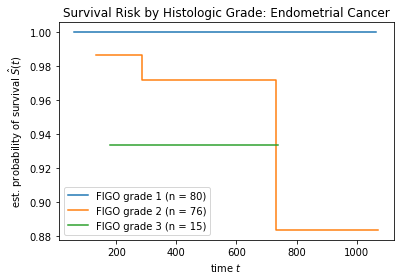

In [10]:
plotKaplanMeier(df = focus_group, 
                col_of_interest = "Histologic_Grade_FIGO", 
                vital_status_col = "Vital Status", 
                time_col = "Path Diag to Last Contact(Day)", 
                title = "Survival Risk by Histologic Grade: Endometrial Cancer", 
                save_plot=True, file_name="KMPlotTest1")

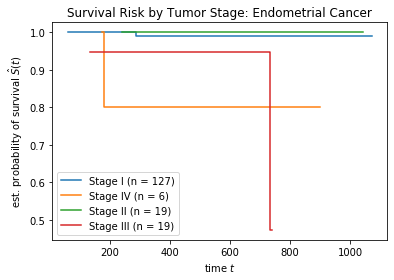

In [11]:
plotKaplanMeier(df = focus_group, 
                col_of_interest = "tumor_Stage-Pathological", 
                vital_status_col = "Vital Status", 
                time_col = "Path Diag to Last Contact(Day)", 
                title = "Survival Risk by Tumor Stage: Endometrial Cancer", 
                save_plot=True, file_name="KMPlotTest2")

## Step 3: Separate the data for pre-processing, and to prepare for Cox Proportional Hazard Test
Cox Proportional Hazard Test is a statistical test used to interpret the significance of Kaplan Meier plots, and potential connections between attributes and an event of interest (in this case, survival).

For the test to be performed properly, our data needs to be in a specific format. It requires data about Vital Status and time to event/last contact to be in a structured array, which we have titled 'survival_array' below.  

Additionally, the attributes we are interested in studying, which are the tumor stage and histologic grade, need to be separate from this array. We separated this data into a DataFrame we call 'tumor_stage_data' below.

In [12]:
tumor_stage_data = focus_group[["tumor_Stage-Pathological",
                                "Histologic_Grade_FIGO"]].copy()
#tumor_stage_data = pd.DataFrame(focus_group['tumor_Stage-Pathological'].copy())

survival_data = focus_group[['Vital Status',
                             "Path Diag to Last Contact(Day)"]].copy()

survival_array = np.zeros(len(survival_data),
                          dtype={"names":("Vital Status",
                                          "Path Diag to Last Contact(Day)"),
                                 "formats":("?", "<f8")})

survival_array['Vital Status'] = survival_data['Vital Status'].values
survival_array['Path Diag to Last Contact(Day)'] = survival_data['Path Diag to Last Contact(Day)'].values 

Sometimes in the conversion, merging, and manipulation of DataFrames, columns' data types get mixed up.  Sci-kit learn requires columns of type "category" or "numeric" to perform pre-processing, which will create a binary DataFrame ready for performing Cox Proportional Hazard, as well as many other predictive analyses.  Oftentimes, these data types become an "object" type, so we will change them to type "category".

In [13]:
for col in tumor_stage_data.columns:
    tumor_stage_data[col] = tumor_stage_data[col].astype("category")

## Step 4: Perform Cox Proportional Hazard Test

In order to perform Cox Proportional Hazard Test, as well as many other Machine Learning and other statistical tests, our data needs to be pre-processed.  This is oftentimes done with Sci-kit Learn's encoder entitled "OneHotEncoder".  OneHotEncoder will create a new binary DataFrame of 0 and 1 for all the attributes in the DataFrame you give it, which will now be in the format for the test to be performed.

In [14]:
for col in tumor_stage_data.columns:
    print(tumor_stage_data[col].value_counts(), '\n')

Stage I      127
Stage III     19
Stage II      19
Stage IV       6
Name: tumor_Stage-Pathological, dtype: int64 

FIGO grade 1    80
FIGO grade 2    76
FIGO grade 3    15
Name: Histologic_Grade_FIGO, dtype: int64 



In [15]:
tumor_stage_numeric = OneHotEncoder().fit_transform(tumor_stage_data)
test2 = OneHotEncoder().fit_transform(tumor_stage_data[["Histologic_Grade_FIGO", "tumor_Stage-Pathological"]])

In [16]:
#What happened to stage I and grade 1?
tumor_stage_numeric.columns

Index(['tumor_Stage-Pathological=Stage II',
       'tumor_Stage-Pathological=Stage III',
       'tumor_Stage-Pathological=Stage IV',
       'Histologic_Grade_FIGO=FIGO grade 2',
       'Histologic_Grade_FIGO=FIGO grade 3'],
      dtype='object')

In [17]:
test2.columns

Index(['Histologic_Grade_FIGO=FIGO grade 2',
       'Histologic_Grade_FIGO=FIGO grade 3',
       'tumor_Stage-Pathological=Stage II',
       'tumor_Stage-Pathological=Stage III',
       'tumor_Stage-Pathological=Stage IV'],
      dtype='object')

Here we will use our estimator of choice, Cox Proportional Hazard, to perform the test.

In [18]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(tumor_stage_numeric, survival_array)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

We can now look at our proportional hazard rations by viewing the following Series, based on the coefficients of the estimator, and the index of the pre-processed data.  These ratios help us know how influential a particular attribute is in relation to survival.  For instance, the ratio of 2.6235030 for Stage III tumors shows us that patients with a Stage III tumor had a 26.2% higher likelihood of death than if they did not have a Stage III tumor.

In [19]:
pd.Series(estimator.coef_, index=tumor_stage_numeric.columns)

tumor_Stage-Pathological=Stage II    -20.501921
tumor_Stage-Pathological=Stage III     2.623530
tumor_Stage-Pathological=Stage IV     25.649083
Histologic_Grade_FIGO=FIGO grade 2    43.161388
Histologic_Grade_FIGO=FIGO grade 3    22.798626
dtype: float64

If you are interested in the accuracy of your model for predicting a positive or negative outcome based on your survival_array, you can view the estimator's "score" method.  This score is particularly relevant when testing your model against new data, but is still helpful in understanding its standalone accuracy as well.

In [20]:
estimator.score(tumor_stage_numeric, survival_array)

0.9274509803921569

Those are the basics of Survival Analysis on the cancer data we have provided in the cptac package.  This is by no means the only way this could have been done.  There are many other questions we could ask ourselves, and continue to study once we get to this point: 

How well does our model hold up for new data? What other attributes may be important for survival? What if I want to study the connection between clinical attributes and the likelihood of developing a second tumor during treatment?

With the functionality and flexibility of cptac, Sci-kit Survival and Sci-kit Learn, these answers can be explored, and a variety of other research projects could be done.  This use case is intended to be a springboard to help researchers get started in survival analysis, and leverage the cancer data we have to find important connections between clinical or molecular attributes and clinical outcomes.